# P-DTW-Experiments

A set of experiments are conducted to investigate the P-DTW method proposed by the Authors in [1]. The experiments aim at answering the following questions. 

1) Are the first second’s bits important for prediction?
2) Is the model bias towards low-variance fingerprints?
3) Does the first bit per second carry identifiable information?
4) Is our proposed FP better for prediction than the FP proposed by the authors?
5) Is variance a good proxy measure for fingerprint quality?

The traces seem to have one very large spike at the beginning and then very little data that follows. I want to investigate that spike and see if I can identify a video based on that. Things I am investigating: 

- Within group and between group distance for each of the 3 videos for the very first BPTS measure. When aggregating the BPTS (bits per time stamp) by: 
- 10-1000 milliseconds in 10ms steps (100 samples)
- 10-1000 on a log scale?

- Within group and between group distance for each of the 3 videos for everything apart from the first BPTS measure. When aggregating the BPTS (bits per time stamp) by the measures above. 

- Within group and between group distance for each of the 3 videos for everything apart from the first BPTS measure. When aggregating the BPTS (bits per time stamp) by the measures above when aggregating the values on the same scale but using a log transformation for the first second, so the values are in the same range as the latter BPTS.  

## Imports

### Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from Utils import *
from itertools import product
import numpy as np
from scipy import stats
import os
import pickle

ModuleNotFoundError: No module named 'Utils'

### Data

In [ ]:
ow = pd.read_pickle("data/closed_world_mega_frame.pkl")
cw = pd.read_pickle("data/open_world_mega_frame.pkl")

ow_ids = ow["video_id"].drop_duplicates().reset_index(drop=True)
cw_ids = cw["video_id"].drop_duplicates().reset_index(drop=True)

display(ow_ids.head(3))
display(cw_ids.head(3))

ow_links = "https://www.youtube.com/watch?v="+ow_ids
cw_links = "https://www.youtube.com/watch?v="+cw_ids


display(ow_links.head(3))
display(ow_links.head(3))
print("Num Ow: ",len(ow_ids))
print("Num Cw: ",len(cw_ids))


ow_ids.to_csv("data/ow_ids.csv")
cw_ids.to_csv("data/cw_ids.csv")

ow_links.to_csv("data/ow_links.csv")
cw_links.to_csv("data/cw_links.csv")


0    3IosA_ir06Y
1    bhpTZOqXRN0
2    agTMr9qITlI
Name: video_id, dtype: object

0    pxZdo1n4pME
1    cTuBm4imTcE
2    BtnXRoKhURs
Name: video_id, dtype: object

0    https://www.youtube.com/watch?v=3IosA_ir06Y
1    https://www.youtube.com/watch?v=bhpTZOqXRN0
2    https://www.youtube.com/watch?v=agTMr9qITlI
Name: video_id, dtype: object

0    https://www.youtube.com/watch?v=3IosA_ir06Y
1    https://www.youtube.com/watch?v=bhpTZOqXRN0
2    https://www.youtube.com/watch?v=agTMr9qITlI
Name: video_id, dtype: object

Num Ow:  50
Num Cw:  3665


In [ ]:
fn = "data/closed_world_mega_frame.pkl"

with open (fn, "rb") as f:
    data = pickle.load(f)

data

,timestamp,data,video_id
0,"[2023-06-22 11:47:33.180000, 2023-06-22 11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",3IosA_ir06Y
1,"[2023-06-22 10:59:57.390000, 2023-06-22 10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",3IosA_ir06Y
2,"[2023-06-22 11:42:14.490000, 2023-06-22 11:42:...","[0.0, 5861.0, 5664.0, 5861.0, 72784.0, 11322.0...",3IosA_ir06Y
3,"[2023-06-22 12:14:02.060000, 2023-06-22 12:14:...","[0.0, 5861.0, 5861.0, 72784.0, 6067.0, 25446.0...",3IosA_ir06Y
4,"[2023-06-22 12:03:27.860000, 2023-06-22 12:03:...","[0.0, 5861.0, 5861.0, 7479.0, 7392.0, 26827.0,...",3IosA_ir06Y
...,...,...,...
2495,"[2023-06-22 07:26:57.450000, 2023-06-22 07:27:...","[0.0, 5861.0, 5861.0, 72757.0, 5931.0, 17722.0...",RvxefSebjYE
2496,"[2023-06-22 07:42:53.870000, 2023-06-22 07:43:...","[0.0, 5861.0, 5861.0, 5891.0, 72757.0, 17722.0...",RvxefSebjYE
2497,"[2023-06-22 06:41:58.490000, 2023-06-22 06:42:...","[0.0, 5861.0, 5924.0, 72757.0, 885.0, 17722.0,...",RvxefSebjYE
2498,"[2023-06-22 08:06:55.740000, 2023-06-22 08:06:...","[5861.0, 5861.0, 72757.0, 5939.0, 17724.0, 268...",RvxefSebjYE


## Data Transformation
Save 100 df for each bin
- name: xms
- columns: video_id, bpp, DF, DF_alt 

### Inspections

In [ ]:
video_ids = list(data.video_id.unique())
video_traces_sizes =  [data.loc[data.video_id == video_id]["data"].reset_index(drop=True).to_list() for video_id in video_ids]

Sizes


/Users/deborahdjon/Documents/ObsidianVaults/Notes/01_MSc_AI/CA694Practicum/Gitlab_Deborah/src/Workbooks/Utils.py:232: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


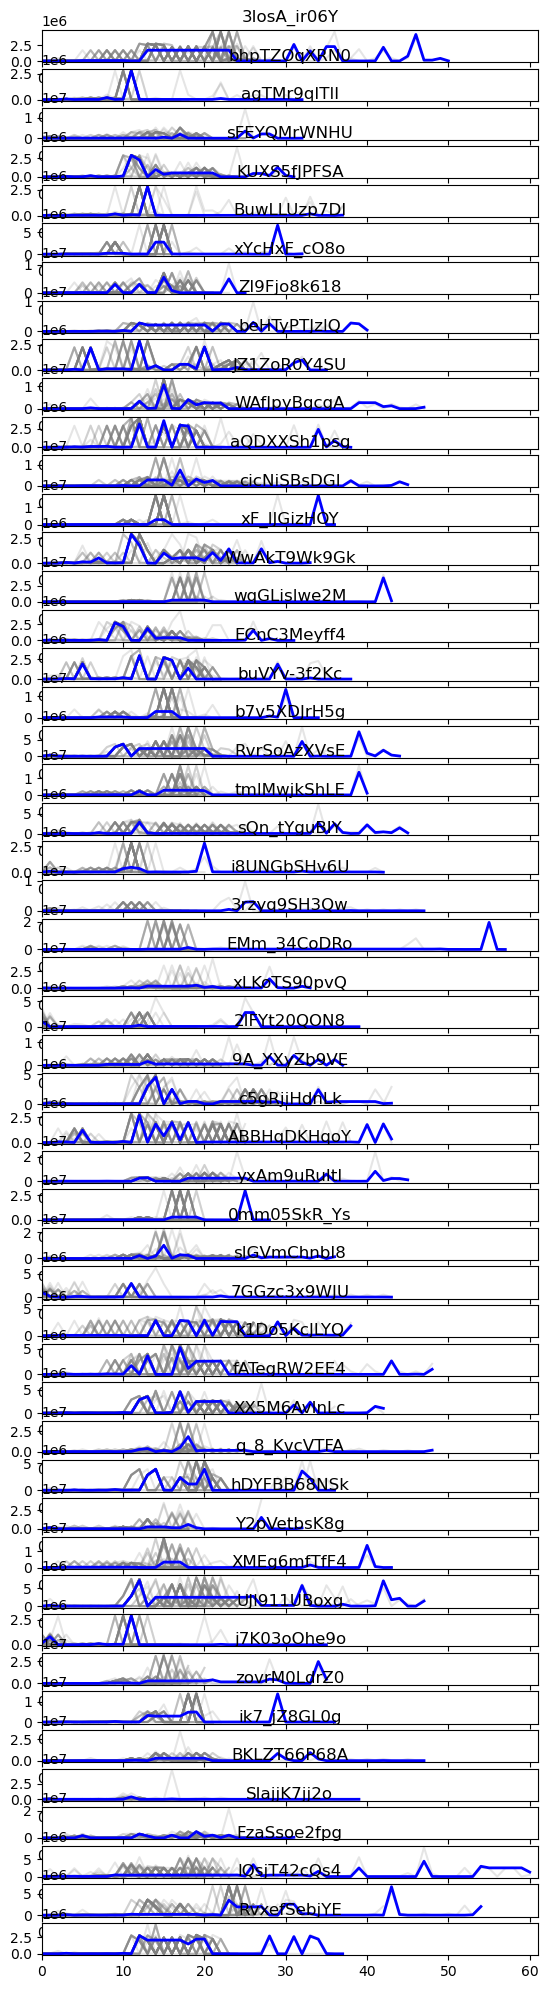

In [ ]:
plot_barycenters(title="Sizes", sequences = video_traces_sizes, sequences_names = video_ids)

### Bin the data into 10 milli seconds


In [ ]:
data_dir = "data/preprocessed_bpp_new_test_data/"
!rm -rf $data_dir 
!mkdir $data_dir

lim=100
ms_bins = list(range(10,1001, 10))[-lim:]

t=6/2
e = 54 #54
for ms in ms_bins: 
    bin_size = timedelta(milliseconds=ms)
    bin_id = f"bp{ms}ms"
    df = youtube_data.copy()
    df["sizes"] = df.apply(lambda row:aggregate_to_interval(timestamps=row[0], bpts=row[1], bin_size=bin_size), axis=1)
    df["bpp"] = df["sizes"].map(lambda bt: bin_per_period(bt=bt, e=e,t=t))
    df["DF"] = df["bpp"].apply(lambda x: DF(x))
    df["DF_alt"] = df["bpp"].apply(lambda x: DF_alt(x))
    df.drop("timestamps", axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df_fn = data_dir+bin_id+"-df.pkl"
    df.to_pickle(df_fn)

In [ ]:
lim=20
filenames =  os.listdir(data_dir)
dfs = {}
for fn in filenames: 
    p = data_dir + fn
    with open(p, "rb") as f: 
        dfs[fn[:-7]]=pickle.load(f)

<AxesSubplot:ylabel='sizes'>

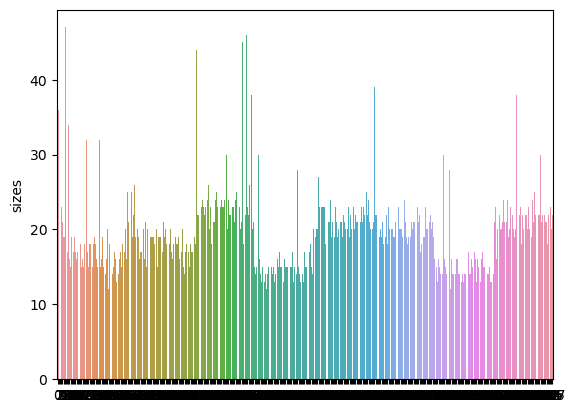

In [ ]:
y = dfs["bp10ms"]["sizes"].map(len)
x = list(range(len(y)))
sns.barplot(x=x, y=y)

<AxesSubplot:ylabel='sizes'>

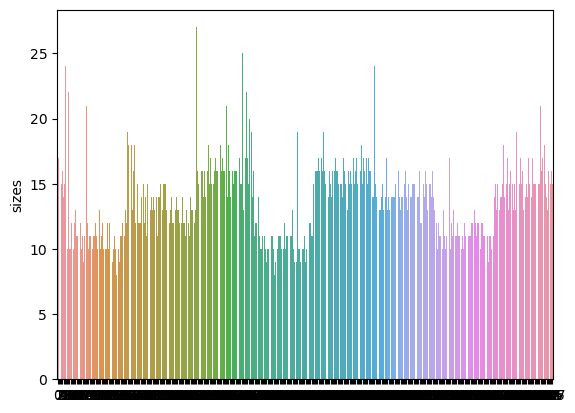

In [ ]:
y = dfs["bp1000ms"]["sizes"].map(len)
x = list(range(len(y)))
sns.barplot(x=x, y=y)

## Experiments

### 1 - Are the first second’s bits important for prediction?

Methodology: 
- Pick a fingerprint: longest
- Predict data using that fingerprint 
- Remove first bps measure from fingerprint and data
- Predict data using the fingerprint
- See if the model is significantly better / worse 
- Test: McNemar test

In [ ]:
#Load
data = dfs["bp1000ms"][["video_id","bpp", "DF"]]
# Create needed columns
data['bpp_no_first'] = data['bpp'].apply(lambda x: x[1:])
data['DF_no_first'] = data['DF'].apply(lambda x: x[1:])
data.head()

/var/folders/qc/zxxkplk90xd364gg1c_mxn780000gn/T/ipykernel_90906/192124954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bpp_no_first'] = data['bpp'].apply(lambda x: x[1:])
/var/folders/qc/zxxkplk90xd364gg1c_mxn780000gn/T/ipykernel_90906/192124954.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DF_no_first'] = data['DF'].apply(lambda x: x[1:])


,video_id,bpp,DF,bpp_no_first,DF_no_first
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[2475160, 2818537, 2273391]","[0.13872921346498812, -0.1934145267562569]"
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[2196752, 1987342, 2269550, 1645]","[-0.09532710110199058, 0.1420027353117883, -0...."
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[775544, 16297607, 3774788]","[20.014419555821462, -0.7683839105949726]"
3,1Oip3b2woQM,"[1956234, 2233535, 2818300, 2699]","[0.1417524692853718, 0.2618114334451889, -0.99...","[2233535, 2818300, 2699]","[0.2618114334451889, -0.9990423304829152]"
4,1Oip3b2woQM,"[574936, 3797738, 2867520, 2274310]","[5.605496959661597, -0.24494001429271844, -0.2...","[3797738, 2867520, 2274310]","[-0.24494001429271844, -0.20687214038611762]"


In [ ]:
# Drop lines that have no fingerprint
data_len_b4 = len(data)
data = data.loc[data.DF_no_first.map(len)>0]
print("Loss: ", 1-(len(data)/data_len_b4))
print("Len",len(data))
data.head(3)

Loss:  0.02392344497607657
Len 408


,video_id,bpp,DF,bpp_no_first,DF_no_first
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[2475160, 2818537, 2273391]","[0.13872921346498812, -0.1934145267562569]"
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[2196752, 1987342, 2269550, 1645]","[-0.09532710110199058, 0.1420027353117883, -0...."
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[775544, 16297607, 3774788]","[20.014419555821462, -0.7683839105949726]"


In [ ]:
# Get fingerprints
video_ids = list(data.video_id.unique())
print("video_ids: ", video_ids)
fps = {}
rm_from_test = [ ]
fps_no_first = {}
for video_id in video_ids: 
    idx = data['DF'].loc[data["video_id"]==video_id].apply(len).idxmax()
    rm_from_test.append(idx)
    fps[video_id] = data['DF'][idx]
    fps_no_first[video_id] = data['DF_no_first'][idx]

print("fps_no_first", fps_no_first)
print("fps", fps)

video_ids:  ['1Oip3b2woQM', 'KUXS5fJPFSA', '7lE63QtGL5A', 'xYcHxF_cO8o', 'TzDeYJV_3OI', 'beHTyPTJzlQ', 'arsStQAhHVA', 'Pn8pwoNWseM', 'bhpTZOqXRN0', 'sFEYQMrWNHU', 'gR8g-mixzkE', 'agTMr9qITlI', 'BuwLLUzp7DI', 'ZI9Fjo8k618']
fps_no_first {'1Oip3b2woQM': [4.7243427320454865, 19.824808161501988, 2.6070625184389136, -0.7913505680911782], 'KUXS5fJPFSA': [-0.4966687451966099, -0.9827766422602261, 44.89462220219318, -0.5488267835818982], '7lE63QtGL5A': [-0.46543042880471297, 0.27655595943722183, -0.318718312940269], 'xYcHxF_cO8o': [0.4936681566410869, -0.9996266070688047], 'TzDeYJV_3OI': [-0.8730640953946818, 0.8854308872313343, 13.530877692506804, -0.014516000712054826, -0.9992818535506418], 'beHTyPTJzlQ': [-0.8840401367363961, 2.7649476460472724, -0.09709872704031404, -0.9993883096429004], 'arsStQAhHVA': [-0.8892986093137795, 213.08921296296296, -0.08035958529749301, -0.9639952613834258, -0.9131127627058869], 'Pn8pwoNWseM': [3.996324334850661, 10.156742377736853, -0.6094587430555738, 1.96814

In [ ]:
# predictions
test = data.copy()
try:
    test = test.drop(rm_from_test, axis=1)
except: 
    pass

X = test["DF"]
X_nf = test["DF_no_first"]
Y = test["video_id"]

threshold = 10000000 # TODO: Max distance before class is called "unknown", 

test["pred"] = [match(fps, x, threshold)[0] for x in X]
test["pred_nf"] = [match(fps, x, threshold)[0] for x in X_nf]
test["pred_dist"] = [match(fps, x, threshold)[1][match(fps, x, threshold)[0]] for x in X]
test["pred_nf_dist"] = [match(fps, x, threshold)[1][match(fps, x, threshold)[0]] for x in X_nf]


test["eval"] = test["pred"] == Y
test["eval_nf"] =  test["pred_nf"] == Y

test

,video_id,bpp,DF,bpp_no_first,DF_no_first,pred,pred_nf,pred_dist,pred_nf_dist,eval,eval_nf
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[2475160, 2818537, 2273391]","[0.13872921346498812, -0.1934145267562569]",7lE63QtGL5A,7lE63QtGL5A,0.106932,0.131565,False,False
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[2196752, 1987342, 2269550, 1645]","[-0.09532710110199058, 0.1420027353117883, -0....",TzDeYJV_3OI,TzDeYJV_3OI,0.152141,0.079112,False,False
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[775544, 16297607, 3774788]","[20.014419555821462, -0.7683839105949726]",1Oip3b2woQM,1Oip3b2woQM,0.110121,0.106289,True,True
3,1Oip3b2woQM,"[1956234, 2233535, 2818300, 2699]","[0.1417524692853718, 0.2618114334451889, -0.99...","[2233535, 2818300, 2699]","[0.2618114334451889, -0.9990423304829152]",TzDeYJV_3OI,xYcHxF_cO8o,0.144278,0.116220,False,False
4,1Oip3b2woQM,"[574936, 3797738, 2867520, 2274310]","[5.605496959661597, -0.24494001429271844, -0.2...","[3797738, 2867520, 2274310]","[-0.24494001429271844, -0.20687214038611762]",bhpTZOqXRN0,BuwLLUzp7DI,0.766304,0.032757,False,False
...,...,...,...,...,...,...,...,...,...,...,...
413,ZI9Fjo8k618,"[5935654, 5376859, 2462153, 2423468]","[-0.09414211138317699, -0.5420833985045916, -0...","[5376859, 2462153, 2423468]","[-0.5420833985045916, -0.015711858686279855]",ZI9Fjo8k618,gR8g-mixzkE,0.171386,0.029291,True,False
414,ZI9Fjo8k618,"[209269, 7416390, 5351564, 5292516]","[34.439506090247484, -0.2784138913946003, -0.0...","[7416390, 5351564, 5292516]","[-0.2784138913946003, -0.011033783768632871]",KUXS5fJPFSA,ZI9Fjo8k618,2.850024,0.120193,False,True
415,ZI9Fjo8k618,"[5451890, 5378976, 2870422, 2423060]","[-0.013374077613451482, -0.4663627426484149, -...","[5378976, 2870422, 2423060]","[-0.4663627426484149, -0.15585234505588377]",beHTyPTJzlQ,ZI9Fjo8k618,0.170581,0.046190,False,True
416,ZI9Fjo8k618,"[5439451, 5376970, 2462337, 2484716]","[-0.011486637162463639, -0.5420586315341168, 0...","[5376970, 2462337, 2484716]","[-0.5420586315341168, 0.009088520377186389]",TzDeYJV_3OI,gR8g-mixzkE,0.184726,0.041704,False,False


In [ ]:
# Are the model predictions the same?
sum(test["eval"]==test["eval_nf"])/len(test)

0.8725490196078431

In [ ]:
# evaluate 
test["eval"] = test["pred"] == Y
test["eval_nf"] =  test["pred_nf"] == Y

accuracy = sum(test["eval"])/(len(test))
accuracy_nf = sum(test["eval_nf"])/len(test)

model_nf_better = "better" if accuracy_nf > accuracy else "worse" if accuracy_nf < accuracy  else "the same as"

print(f"The the model without the first bpp measure performs {model_nf_better} than the model with the first bpp measure")

print("Accuracy with first bpp: ", accuracy)
print("Accuracy without first bpp: ", accuracy_nf)


# Investigate significance using MC Nemar test
#Mcnemar test
m1 = test["eval"].to_list()
m2 = test["eval_nf"].to_list()
contingency_table = [[x,y] for x,y in zip(m1, m2)]
m1tm2f = sum([1 for xy in contingency_table if xy[0]==1 and xy[1]==0])
m2fm1t = sum([1 for xy in contingency_table if xy[0]==0 and xy[1]==1])

try:
    chi2_value = ((m1tm2f-m2fm1t)**2)/(m1tm2f+m2fm1t)
except(ZeroDivisionError): 
    chi2_value = 0
df = 1

p_value = 1 - stats.chi2.cdf(chi2_value, df)

significant = "significant" if p_value < 0.05 else "not significant"
print(f"The the model performance difference is {significant}.")

The the model without the first bpp measure performs better than the model with the first bpp measure
Accuracy with first bpp:  0.10784313725490197
Accuracy without first bpp:  0.12745098039215685
The the model performance difference is not significant.


### 2 - Is the model bias towards low-variance fingerprints?

#### Methodology I 
- Get the variance means of inputs and outputs and check if they are significantly different
- Test 
- Don't think this is right because I could have much lower variance in my input and a much higher variance in my outputs (I specifically picked values far appart from another)
- test


In [ ]:
Y_hat = test["pred"].map(fps)
Y_hat = [np.var(y) for y in Y_hat]
X =  test["DF"] 
X = [np.var(x) for x in X]
print(Y_hat)
print(X)

[42.18882517083245, 288.48189727233824, 58.78740328471544, 288.48189727233824, 3.3098728465263916, 3.3098728465263916, 3.3098728465263916, 58.78740328471544, 6234.75900892377, 351.8632962801684, 6234.75900892377, 351.8632962801684, 6234.75900892377, 6234.75900892377, 6234.75900892377, 42.321135811103, 6234.75900892377, 6234.75900892377, 6234.75900892377, 15.941074525873976, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 288.48189727233824, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 604.0842622019702, 351.8632962801684, 6234.75900892377, 351.8632962801684, 6234.75900892377, 6234.75900892377, 15.941074525873976, 6234.75900892377, 351.8632962801684, 351.8632962801684, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 6234.75900892377, 351.8632962801684, 6234.75900892377, 6234.75900892377, 351.8632962801684, 6234.75900892377, 6234.75900892377, 

In [ ]:
# data follows a normal distribution (Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(X)
print("Shapiro-Wilk test input variances")
print("Test statistic:", shapiro_stat)
print("p-value:", shapiro_p)
if shapiro_p >= 0.05:
    print("The data sample appears to be normally distributed.")
else:
    print("The data sample does not appear to be normally distributed.")

Shapiro-Wilk test input variances
Test statistic: 0.231187105178833
p-value: 8.653879535501612e-38
The data sample does not appear to be normally distributed.


In [ ]:
# data follows a normal distribution (Shapiro-Wilk test)

shapiro_stat, shapiro_p = stats.shapiro(Y_hat)
print("Shapiro-Wilk test prediction variances")
print("Test statistic:", shapiro_stat)
print("p-value:", shapiro_p)
if shapiro_p >= 0.05:
    print("The data sample appears to be normally distributed.")
else:
    print("The data sample does not appear to be normally distributed.")

Shapiro-Wilk test prediction variances
Test statistic: 0.6215322017669678
p-value: 5.742534481823484e-29
The data sample does not appear to be normally distributed.


In [ ]:
# Wilcoxion sink-rank test: non-parametric paired t-test alternative
print("Wilcoxon signed-rank test of model input and output variances")
# Perform Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(X, Y_hat)

print("Mean variance input: ", np.mean(X))
print("Mean variance output: ", np.mean(Y_hat))

# Print the test statistic and p-value
print("Wilcoxon signed-rank statistic:", statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print("Variance difference is significant.")
else:
    print("Variance difference is not significant.")

Wilcoxon signed-rank test of model input and output variances
Mean variance input:  21420.491139895676
Mean variance output:  2589.232109607954
Wilcoxon signed-rank statistic: 16533.0
p-value: 4.519866582784882e-23
Variance difference is significant.


#### Methodology II
- Pick the fingerprints: longest
- Rank fingerprints based on variance
- Get the proportions of fingerprint classes in prediction and label
- Check that the difference in the proportions are different from one another
- Check that the proportions are always less than in the output using Chi²

In [ ]:
fps_var = {k: np.var(v) for k,v in fps.items()}
fps_var

{'1Oip3b2woQM': 58.78740328471544,
 'KUXS5fJPFSA': 351.8632962801684,
 '7lE63QtGL5A': 42.18882517083245,
 'xYcHxF_cO8o': 42.321135811103,
 'TzDeYJV_3OI': 288.48189727233824,
 'beHTyPTJzlQ': 604.0842622019702,
 'arsStQAhHVA': 6234.75900892377,
 'Pn8pwoNWseM': 15.941074525873976,
 'bhpTZOqXRN0': 3.3098728465263916,
 'sFEYQMrWNHU': 61.16792427802667,
 'gR8g-mixzkE': 13082.673636370857,
 'agTMr9qITlI': 105.00960237763194,
 'BuwLLUzp7DI': 1224.7101510597863,
 'ZI9Fjo8k618': 1728.7823321600529}

In [ ]:
fps_keys_sorted = sorted(fps, key=lambda k: fps[k])
fps_keys_sorted

['1Oip3b2woQM',
 'Pn8pwoNWseM',
 'bhpTZOqXRN0',
 'arsStQAhHVA',
 'xYcHxF_cO8o',
 '7lE63QtGL5A',
 'sFEYQMrWNHU',
 'agTMr9qITlI',
 'KUXS5fJPFSA',
 'gR8g-mixzkE',
 'TzDeYJV_3OI',
 'beHTyPTJzlQ',
 'BuwLLUzp7DI',
 'ZI9Fjo8k618']

According to the above list I expect this order in predictions if the model is predicting high-variance traces more often
- capture 3
- capture 4
- Capture 1

In [ ]:
fps_var = {k: np.var(v[1:]) for k,v in fps.items()}
fps_var

{'1Oip3b2woQM': 62.24723634812564,
 'KUXS5fJPFSA': 389.41496300967447,
 '7lE63QtGL5A': 0.10293552273692048,
 'xYcHxF_cO8o': 0.5574823128308452,
 'TzDeYJV_3OI': 30.84644965324254,
 'beHTyPTJzlQ': 2.320209683879413,
 'arsStQAhHVA': 7313.839154006608,
 'Pn8pwoNWseM': 15.805360111274894,
 'bhpTZOqXRN0': 0.00046972454481870705,
 'sFEYQMrWNHU': 0.46598607765670824,
 'gR8g-mixzkE': 16188.665460755537,
 'agTMr9qITlI': 1.868487227661151,
 'BuwLLUzp7DI': 0.03359972386029299,
 'ZI9Fjo8k618': 0.6770507065198051}

Or

According to the above list I expect this order in predictions if the model is predicting high-variance traces more often
- capture 4
- capture 1
- Capture 3

In [ ]:
# Compute the observed frequencies
print("Calculate class counts of videos: ", fps_keys_sorted)
observed1 = []
counts = [input.count(v_id) for v_id in fps_keys_sorted]
for i in range(len(counts)-1):
    observed1.append(abs(counts[i]-counts[i+1]))


observed2 = []
counts = [output.count(v_id) for v_id in fps_keys_sorted]
for i in range(len(counts)-1):
    observed2.append(abs(counts[i]-counts[i+1]))

Calculate class counts of videos:  ['1Oip3b2woQM', 'Pn8pwoNWseM', 'bhpTZOqXRN0', 'arsStQAhHVA', 'xYcHxF_cO8o', '7lE63QtGL5A', 'sFEYQMrWNHU', 'agTMr9qITlI', 'KUXS5fJPFSA', 'gR8g-mixzkE', 'TzDeYJV_3OI', 'beHTyPTJzlQ', 'BuwLLUzp7DI', 'ZI9Fjo8k618']


In [ ]:
# Do the proportions of the video_ids in the labels and predictions differ significantly?

# Two lists with categorical values
input = test['pred'].to_list()
output = test["video_id"].to_list()

# Compute the observed frequencies
print("Calculate class counts of videos: ", fps_keys_sorted)
observed1 = [input.count(v_id) for v_id in fps_keys_sorted]
observed2 = [output.count(v_id) for v_id in fps_keys_sorted]
print("Labels: ", observed1)
print("Predictions: ", observed2)

# Expected frequencies assuming equal proportions
expected = np.mean([observed1, observed2], axis=0)

# Chi-square test for proportions in each list
chi2_stat1, p_value1 = stats.chisquare(f_obs=observed1, f_exp=expected)
chi2_stat2, p_value2 = stats.chisquare(f_obs=observed2, f_exp=expected)

# Print the results
print("List 1:")
print("Chi-square statistic:", chi2_stat1)
print("P-value:", p_value1)

print("\nList 2:")
print("Chi-square statistic:", chi2_stat2)
print("P-value:", p_value2)

Calculate class counts of videos:  ['1Oip3b2woQM', 'Pn8pwoNWseM', 'bhpTZOqXRN0', 'arsStQAhHVA', 'xYcHxF_cO8o', '7lE63QtGL5A', 'sFEYQMrWNHU', 'agTMr9qITlI', 'KUXS5fJPFSA', 'gR8g-mixzkE', 'TzDeYJV_3OI', 'beHTyPTJzlQ', 'BuwLLUzp7DI', 'ZI9Fjo8k618']
Labels:  [25, 51, 18, 51, 11, 10, 35, 7, 40, 47, 42, 40, 3, 38]
Predictions:  [9, 9, 50, 1, 50, 8, 50, 50, 50, 2, 1, 38, 50, 50]
List 1:
Chi-square statistic: 142.60250904368155
P-value: 6.3299829181575604e-24

List 2:
Chi-square statistic: 142.60250904368155
P-value: 6.3299829181575604e-24


In [ ]:
# Chi-square test for comparing the proportions between the lists
chi2_stat_comp, p_value_comp = stats.chisquare(f_obs=[observed1, observed2])
print("\nComparison of proportions between lists:")
print("Chi-square statistic:", chi2_stat_comp)
print("P-value:", p_value_comp)


Comparison of proportions between lists:
Chi-square statistic: [ 7.52941176 29.4        15.05882353 48.07692308 24.93442623  0.22222222
  2.64705882 32.43859649  1.11111111 41.32653061 39.09302326  0.05128205
 41.67924528  1.63636364]
P-value: [6.06997236e-03 5.88776427e-08 1.04211945e-04 4.09821544e-12
 5.93137351e-07 6.37351888e-01 1.03741678e-01 1.23018720e-08
 2.91840545e-01 1.28808724e-10 4.04085428e-10 8.20847239e-01
 1.07544596e-10 2.00825123e-01]


### 3 - Does the first bit per second carry identifiable information?
Methodology

- Stretch out the first bpp measure
- Predict videos and get the accuracy
- Check if the accuracy us bettrer than random which is 1/3
- Plot the accuracy over increasing bin size

In [ ]:
#Load
data = dfs["bp10ms"][["video_id","bpp", "DF"]]

In [ ]:
# Create needed columns
data['bpp_no_first'] = data['bpp'].apply(lambda x: x[1:])
data['DF_no_first'] = data['DF'].apply(lambda x: x[1:])
data.head()

/var/folders/qc/zxxkplk90xd364gg1c_mxn780000gn/T/ipykernel_90906/153770979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bpp_no_first'] = data['bpp'].apply(lambda x: x[1:])
/var/folders/qc/zxxkplk90xd364gg1c_mxn780000gn/T/ipykernel_90906/153770979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DF_no_first'] = data['DF'].apply(lambda x: x[1:])


,video_id,bpp,DF,bpp_no_first,DF_no_first
0,1Oip3b2woQM,"[430489, 1598155, 2489812, 2868074, 4485359]","[2.712417738896929, 0.5579289868629763, 0.1519...","[1598155, 2489812, 2868074, 4485359]","[0.5579289868629763, 0.1519239203602521, 0.563..."
1,1Oip3b2woQM,"[348964, 207456, 3456255, 2156598, 31962, 1510...","[-0.4055088777065829, 15.660183364183249, -0.3...","[207456, 3456255, 2156598, 31962, 1510829, 108...","[15.660183364183249, -0.3760304144225469, -0.9..."
2,1Oip3b2woQM,"[87809, 128196, 668888, 11875921, 3774517, 178...","[0.4599414638590577, 4.217697900090487, 16.754...","[128196, 668888, 11875921, 3774517, 1781378]","[4.217697900090487, 16.754722763751182, -0.682..."
3,1Oip3b2woQM,"[90803, 112829, 294696, 2266280, 2215126, 2699]","[0.24256907811415923, 1.611881697081424, 6.690...","[112829, 294696, 2266280, 2215126, 2699]","[1.611881697081424, 6.690229931861986, -0.0225..."
4,1Oip3b2woQM,"[430478, 101183, 4066865, 2868209, 2214527, 1508]","[-0.7649519836089185, 39.19316485970963, -0.29...","[101183, 4066865, 2868209, 2214527, 1508]","[39.19316485970963, -0.2947371009364707, -0.22..."


In [ ]:
# Drop lines that have no fingerprint
data_len_b4 = len(data)
data = data.loc[data.DF_no_first.map(len)>0]
print("Loss: ", 1-(len(data)/data_len_b4))
print("Len",len(data))
data.head(3)

Loss:  0.0
Len 418


,video_id,bpp,DF,bpp_no_first,DF_no_first
0,1Oip3b2woQM,"[430489, 1598155, 2489812, 2868074, 4485359]","[2.712417738896929, 0.5579289868629763, 0.1519...","[1598155, 2489812, 2868074, 4485359]","[0.5579289868629763, 0.1519239203602521, 0.563..."
1,1Oip3b2woQM,"[348964, 207456, 3456255, 2156598, 31962, 1510...","[-0.4055088777065829, 15.660183364183249, -0.3...","[207456, 3456255, 2156598, 31962, 1510829, 108...","[15.660183364183249, -0.3760304144225469, -0.9..."
2,1Oip3b2woQM,"[87809, 128196, 668888, 11875921, 3774517, 178...","[0.4599414638590577, 4.217697900090487, 16.754...","[128196, 668888, 11875921, 3774517, 1781378]","[4.217697900090487, 16.754722763751182, -0.682..."


In [ ]:
# Get fingerprints
video_ids = list(data.video_id.unique())
print("video_ids: ", video_ids)
fps = {}
rm_from_test = [ ]
fps_no_first = {}
for video_id in video_ids: 
    idx = data['DF'].loc[data["video_id"]==video_id].apply(len).idxmax()
    rm_from_test.append(idx)
    fps[video_id] = data['DF'][idx]
    fps_no_first[video_id] = data['DF_no_first'][idx]

print("fps_no_first", fps_no_first)
print("fps", fps)

video_ids:  ['1Oip3b2woQM', 'KUXS5fJPFSA', '7lE63QtGL5A', 'xYcHxF_cO8o', 'TzDeYJV_3OI', 'beHTyPTJzlQ', 'arsStQAhHVA', 'Pn8pwoNWseM', 'bhpTZOqXRN0', 'sFEYQMrWNHU', 'gR8g-mixzkE', 'agTMr9qITlI', 'BuwLLUzp7DI', 'ZI9Fjo8k618']
fps_no_first {'1Oip3b2woQM': [-0.3420305233919041, 8.323308983967365, -0.45058355464656025, -0.5304843041022317, -0.6679289193933298, 342.6919284908238, -0.8448022816296772, -0.9368002503092678, 224.91273630613648, -0.5674357603980041], 'KUXS5fJPFSA': [4.298637048045523, 5.053858956994763, 0.41137079095535467, -0.9811649671066129, 0.9447107115830027, 20.512281405138967, -0.5475490405666593], '7lE63QtGL5A': [66.37857859056285, -0.3704807582961968, 0.1125718743373554, -0.8610413439937489, 3.7652247338452938], 'xYcHxF_cO8o': [32.20680430189334, -0.7062680877991514, -0.9982729611594306], 'TzDeYJV_3OI': [-0.9679667577130654, 0.024257482621933706, 2.703324593014288, 5.402521676574155, -0.6694891098008835, 5.096227481910378, 1.3518971061470748, -0.9797357106372294, 15.56274

In [ ]:
# predictions
#test = data.drop(rm_from_test, axis=1)

X = test["DF"]
X_nf = test["DF_no_first"]
Y = test["video_id"]

threshold = 10000000 # TODO: Max distance before class is called "unknown", 

test["pred"] = [match(fps, x, threshold)[0] for x in X]
test["pred_nf"] = [match(fps, x, threshold)[0] for x in X_nf]
test["pred_dist"] = [match(fps, x, threshold)[1][match(fps, x, threshold)[0]] for x in X]
test["pred_nf_dist"] = [match(fps, x, threshold)[1][match(fps, x, threshold)[0]] for x in X_nf]

test["eval"] = test["pred"] == Y
test["eval_nf"] =  test["pred_nf"] == Y

test

,video_id,bpp,DF,bpp_no_first,DF_no_first,pred,pred_nf,pred_dist,pred_nf_dist,eval,eval_nf
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[2475160, 2818537, 2273391]","[0.13872921346498812, -0.1934145267562569]",ZI9Fjo8k618,TzDeYJV_3OI,0.143949,0.166072,False,False
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[2196752, 1987342, 2269550, 1645]","[-0.09532710110199058, 0.1420027353117883, -0....",ZI9Fjo8k618,ZI9Fjo8k618,0.117114,0.090004,False,False
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[775544, 16297607, 3774788]","[20.014419555821462, -0.7683839105949726]",KUXS5fJPFSA,KUXS5fJPFSA,0.304397,0.359348,False,False
3,1Oip3b2woQM,"[1956234, 2233535, 2818300, 2699]","[0.1417524692853718, 0.2618114334451889, -0.99...","[2233535, 2818300, 2699]","[0.2618114334451889, -0.9990423304829152]",ZI9Fjo8k618,Pn8pwoNWseM,0.040148,0.043008,False,False
4,1Oip3b2woQM,"[574936, 3797738, 2867520, 2274310]","[5.605496959661597, -0.24494001429271844, -0.2...","[3797738, 2867520, 2274310]","[-0.24494001429271844, -0.20687214038611762]",beHTyPTJzlQ,7lE63QtGL5A,0.275269,0.019034,False,False
...,...,...,...,...,...,...,...,...,...,...,...
413,ZI9Fjo8k618,"[5935654, 5376859, 2462153, 2423468]","[-0.09414211138317699, -0.5420833985045916, -0...","[5376859, 2462153, 2423468]","[-0.5420833985045916, -0.015711858686279855]",7lE63QtGL5A,7lE63QtGL5A,0.140266,0.149943,False,False
414,ZI9Fjo8k618,"[209269, 7416390, 5351564, 5292516]","[34.439506090247484, -0.2784138913946003, -0.0...","[7416390, 5351564, 5292516]","[-0.2784138913946003, -0.011033783768632871]",Pn8pwoNWseM,7lE63QtGL5A,0.821389,0.107836,False,False
415,ZI9Fjo8k618,"[5451890, 5378976, 2870422, 2423060]","[-0.013374077613451482, -0.4663627426484149, -...","[5378976, 2870422, 2423060]","[-0.4663627426484149, -0.15585234505588377]",beHTyPTJzlQ,1Oip3b2woQM,0.158874,0.155255,False,False
416,ZI9Fjo8k618,"[5439451, 5376970, 2462337, 2484716]","[-0.011486637162463639, -0.5420586315341168, 0...","[5376970, 2462337, 2484716]","[-0.5420586315341168, 0.009088520377186389]",7lE63QtGL5A,7lE63QtGL5A,0.159542,0.137531,False,False


In [ ]:
# Are the model predictions the same?
sum(test["eval"]==test["eval_nf"])/len(test)
# yes they are exactly the same

0.9117647058823529

In [ ]:
# evaluate 
test["eval"] = test["pred"] == Y
test["eval_nf"] =  test["pred_nf"] == Y

accuracy = sum(test["eval"])/(len(test))
accuracy_nf = sum(test["eval_nf"])/len(test)

model_nf_better = "better" if accuracy_nf > accuracy else "worse" if accuracy_nf < accuracy  else "the same as"

print(f"The the model without the first bpp measure performs {model_nf_better} than the model with the first bpp measure")

print("Accuracy with first bpp: ", accuracy)
print("Accuracy without first bpp: ", accuracy_nf)


# Investigate significance using MC Nemar test
#Mcnemar test
m1 = test["eval"].to_list()
m2 = test["eval_nf"].to_list()
contingency_table = [[x,y] for x,y in zip(m1, m2)]
m1tm2f = sum([1 for xy in contingency_table if xy[0]==1 and xy[1]==0])
m2fm1t = sum([1 for xy in contingency_table if xy[0]==0 and xy[1]==1])

try:
    chi2_value = ((m1tm2f-m2fm1t)**2)/(m1tm2f+m2fm1t)
except(ZeroDivisionError): 
    chi2_value = 0
df = 1

p_value = 1 - stats.chi2.cdf(chi2_value, df)

significant = "significant" if p_value < 0.05 else "not significant"
print(f"The the model performance difference is {significant}.")

The the model without the first bpp measure performs worse than the model with the first bpp measure
Accuracy with first bpp:  0.058823529411764705
Accuracy without first bpp:  0.04411764705882353
The the model performance difference is not significant.


In [ ]:
# Plot accuracy with increasing bin size
accuracies = []
ms_bins = list(range( 10,1001, 10))

for ms_bin in ms_bins:
    data = dfs[f"bp{ms_bin}ms"][["video_id","bpp", "DF"]]

    # Drop lines that have no fingerprint
    data = data.loc[data.DF.map(len)>0]

    # Get fingerprints
    video_ids = list(data.video_id.unique())
    fps = {}
    rm_data= [ ]
    for video_id in video_ids: 
        idx = data['DF'].loc[data["video_id"]==video_id].apply(len).idxmax()
        rm_data.append(idx)
        fps[video_id] = data['DF'][idx]

    try:
        data = data.drop(rm_from_data, axis=1)
    except: 
        pass


    X = data["DF"]
    Y = data["video_id"]

    threshold = 10000000 # TODO: Max distance before class is called "unknown", 
    predictions = [match(fps, x, threshold)[0] for x in X]
    evaluation = predictions == Y
    accuracies.append(sum(evaluation)/len(evaluation))
print(accuracies)


[0.12440191387559808, 0.16267942583732056, 0.12679425837320574, 0.11244019138755981, 0.12440191387559808, 0.11004784688995216, 0.08851674641148326, 0.12440191387559808, 0.10526315789473684, 0.11004784688995216, 0.11483253588516747, 0.07894736842105263, 0.07416267942583732, 0.06937799043062201, 0.09330143540669857, 0.07894736842105263, 0.11004784688995216, 0.11483253588516747, 0.12200956937799043, 0.11483253588516747, 0.1291866028708134, 0.11244019138755981, 0.11244019138755981, 0.11483253588516747, 0.11722488038277512, 0.09330143540669857, 0.10047846889952153, 0.09330143540669857, 0.09808612440191387, 0.09808612440191387, 0.10047846889952153, 0.11483253588516747, 0.10526315789473684, 0.10287081339712918, 0.10047846889952153, 0.10047846889952153, 0.09090909090909091, 0.11004784688995216, 0.12679425837320574, 0.12200956937799043, 0.1291866028708134, 0.11722488038277512, 0.09808612440191387, 0.09808612440191387, 0.09330143540669857, 0.10287081339712918, 0.12679425837320574, 0.119617224880

<AxesSubplot:>

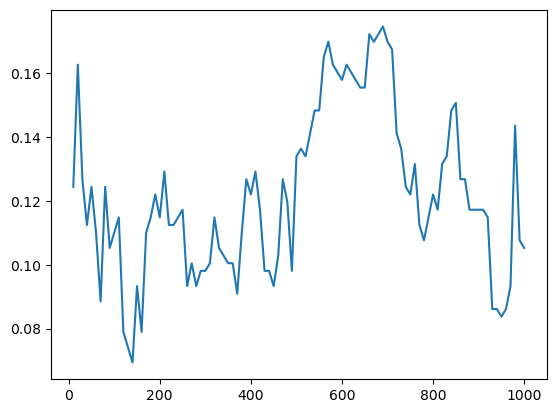

In [ ]:
sns.lineplot(x=ms_bins, y = accuracies)

### 4 - Is our proposed FP better for prediction than the FP proposed by the authors?

In [ ]:
#Load
data = dfs["bp1000ms"][["video_id","bpp", "DF"]]
# Create needed columns
data['DF_alt'] = data['bpp'].apply(lambda x: DF_alt(x))

/var/folders/qc/zxxkplk90xd364gg1c_mxn780000gn/T/ipykernel_90906/2816149958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DF_alt'] = data['bpp'].apply(lambda x: DF_alt(x))


In [ ]:
# Drop lines that have no fingerprint
data_len_b4 = len(data)
data = data.loc[data.DF.map(len)>0]
print("Loss: ", 1-(len(data)/data_len_b4))
print("Len",len(data))
data.head(3)

Loss:  0.0
Len 418


,video_id,bpp,DF,DF_alt
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[0.09864921488278282, 0.06486525390478526, -0...."
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[0.15136045686444488, -0.050049066775268436, 0..."
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[-0.6483589428061405, 0.909150455003883, -0.62..."


In [ ]:
# Get fingerprints
video_ids = list(data.video_id.unique())
print("video_ids: ", video_ids)
fps = {}
rm_from_test = [ ]
fps_alt= {}
for video_id in video_ids: 
    idx = data['DF'].loc[data["video_id"]==video_id].apply(len).idxmax()
    rm_from_test.append(idx)
    fps[video_id] = data['DF'][idx]
    fps_alt[video_id] = data['DF_alt'][idx]

print("fps", fps)
print("fps_alt", fps_alt)

video_ids:  ['1Oip3b2woQM', 'KUXS5fJPFSA', '7lE63QtGL5A', 'xYcHxF_cO8o', 'TzDeYJV_3OI', 'beHTyPTJzlQ', 'arsStQAhHVA', 'Pn8pwoNWseM', 'bhpTZOqXRN0', 'sFEYQMrWNHU', 'gR8g-mixzkE', 'agTMr9qITlI', 'BuwLLUzp7DI', 'ZI9Fjo8k618']
fps {'1Oip3b2woQM': [-0.9044556257940566, 4.7243427320454865, 19.824808161501988, 2.6070625184389136, -0.7913505680911782], 'KUXS5fJPFSA': [26.59332478919126, -0.4966687451966099, -0.9827766422602261, 44.89462220219318, -0.5488267835818982], '7lE63QtGL5A': [14.817307184758473, -0.46543042880471297, 0.27655595943722183, -0.318718312940269], 'xYcHxF_cO8o': [13.486477249169361, 0.4936681566410869, -0.9996266070688047], 'TzDeYJV_3OI': [46.002911780908164, -0.8730640953946818, 0.8854308872313343, 13.530877692506804, -0.014516000712054826, -0.9992818535506418], 'beHTyPTJzlQ': [61.54694529449775, -0.8840401367363961, 2.7649476460472724, -0.09709872704031404, -0.9993883096429004], 'arsStQAhHVA': [10.311603234876372, -0.8892986093137795, 213.08921296296296, -0.080359585297493

In [ ]:
# predictions
test = data
try:
    test = data.drop(rm_from_test, axis=1)
except: 
    pass

X = test["DF"]
X_alt = test["DF_alt"]
Y = test["video_id"]

threshold = 10000000 # TODO: Max distance before class is called "unknown", 

test["pred"] = [match(fps, x, threshold)[0] for x in X]
test["pred_alt"] = [match(fps_alt, x, threshold)[0] for x in X_alt]
test["pred_dist"] = [match(fps, x, threshold)[1][match(fps, x, threshold)[0]] for x in X]
test["pred_alt_dist"] = [match(fps_alt, x, threshold)[1][match(fps_alt, x, threshold)[0]] for x in X_alt]
test

,video_id,bpp,DF,DF_alt,pred,pred_alt,pred_dist,pred_alt_dist
0,1Oip3b2woQM,"[2030664, 2475160, 2818537, 2273391]","[0.2188919486433994, 0.13872921346498812, -0.1...","[0.09864921488278282, 0.06486525390478526, -0....",7lE63QtGL5A,7lE63QtGL5A,0.106932,0.053984
1,1Oip3b2woQM,"[1619172, 2196752, 1987342, 2269550, 1645]","[0.35671318426949084, -0.09532710110199058, 0....","[0.15136045686444488, -0.050049066775268436, 0...",TzDeYJV_3OI,TzDeYJV_3OI,0.152141,0.067965
2,1Oip3b2woQM,"[3635454, 775544, 16297607, 3774788]","[-0.7866720360098078, 20.014419555821462, -0.7...","[-0.6483589428061405, 0.909150455003883, -0.62...",1Oip3b2woQM,1Oip3b2woQM,0.110121,0.069621
3,1Oip3b2woQM,"[1956234, 2233535, 2818300, 2699]","[0.1417524692853718, 0.2618114334451889, -0.99...","[0.06618527178944711, 0.11575298876546838, -0....",TzDeYJV_3OI,TzDeYJV_3OI,0.144278,0.065680
4,1Oip3b2woQM,"[574936, 3797738, 2867520, 2274310]","[5.605496959661597, -0.24494001429271844, -0.2...","[0.7370323056326632, -0.13956218949063937, -0....",bhpTZOqXRN0,BuwLLUzp7DI,0.766304,0.093607
...,...,...,...,...,...,...,...,...
413,ZI9Fjo8k618,"[5935654, 5376859, 2462153, 2423468]","[-0.09414211138317699, -0.5420833985045916, -0...","[-0.04939618632924444, -0.3718205814712364, -0...",ZI9Fjo8k618,ZI9Fjo8k618,0.171386,0.119073
414,ZI9Fjo8k618,"[209269, 7416390, 5351564, 5292516]","[34.439506090247484, -0.2784138913946003, -0.0...","[0.9451145140374098, -0.16171941095652442, -0....",KUXS5fJPFSA,BuwLLUzp7DI,2.850024,0.062252
415,ZI9Fjo8k618,"[5451890, 5378976, 2870422, 2423060]","[-0.013374077613451482, -0.4663627426484149, -...","[-0.00673205632864445, -0.304089340822203, -0....",beHTyPTJzlQ,beHTyPTJzlQ,0.170581,0.110281
416,ZI9Fjo8k618,"[5439451, 5376970, 2462337, 2484716]","[-0.011486637162463639, -0.5420586315341168, 0...","[-0.005776494831330992, -0.3717972774889413, 0...",TzDeYJV_3OI,TzDeYJV_3OI,0.184726,0.125952


In [ ]:
# evaluate 
test["eval"] = test["pred"] == Y
test["eval_alt"] =  test["pred_alt"] == Y

accuracy = sum(test["eval"])/(len(test))
accuracy_alt = sum(test["eval_alt"])/len(test)

model_alt_better = "better" if accuracy_alt > accuracy else "worse" if accuracy_alt < accuracy  else "the same as"

print(f"The the model with the alternative DF performs {model_alt_better} than the model with the proposed DF")

print("Accuracy with proposed DF: ", accuracy)
print("Accuracy with alt DF", accuracy_alt)

The the model with the alternative DF performs better than the model with the proposed DF
Accuracy with proposed DF:  0.10526315789473684
Accuracy with alt DF 0.1339712918660287


In [ ]:
# Investigate significance using MC Nemar test
#Mcnemar test
m1 = test["eval"].to_list()
m2 = test["eval_alt"].to_list()
contingency_table = [[x,y] for x,y in zip(m1, m2)]
m1tm2f = sum([1 for xy in contingency_table if xy[0]==1 and xy[1]==0])
m2fm1t = sum([1 for xy in contingency_table if xy[0]==0 and xy[1]==1])

try:
    chi2_value = ((m1tm2f-m2fm1t)**2)/(m1tm2f+m2fm1t)
except(ZeroDivisionError): 
    chi2_value = 0
df = 1

p_value = 1 - stats.chi2.cdf(chi2_value, df)

significant = "significant" if p_value < 0.05 else "not significant"
print(f"The the model performance difference is {significant}.")

The the model performance difference is significant.


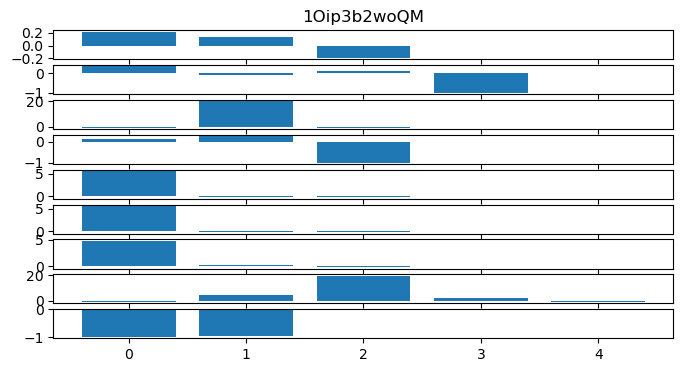

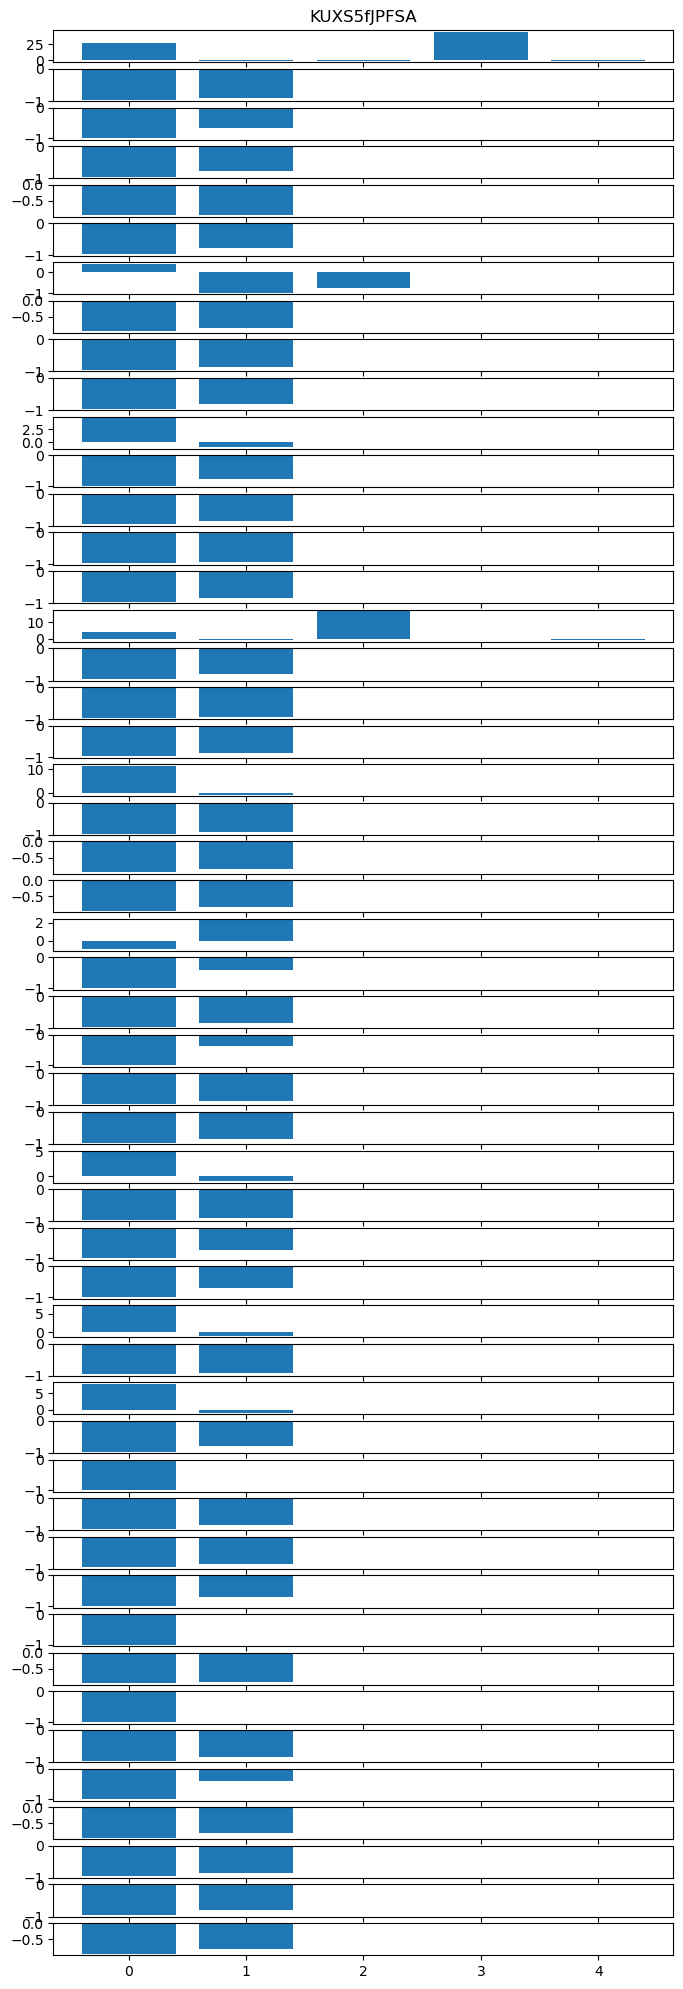

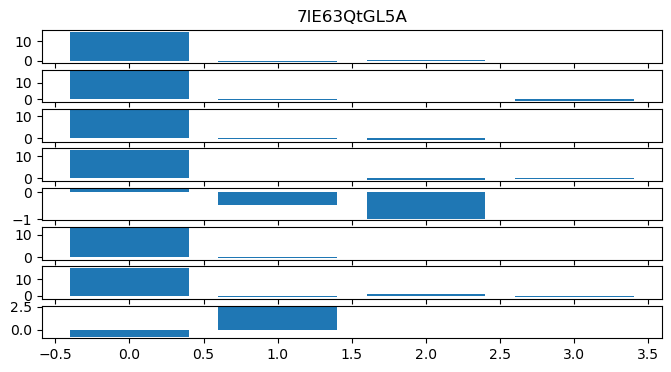

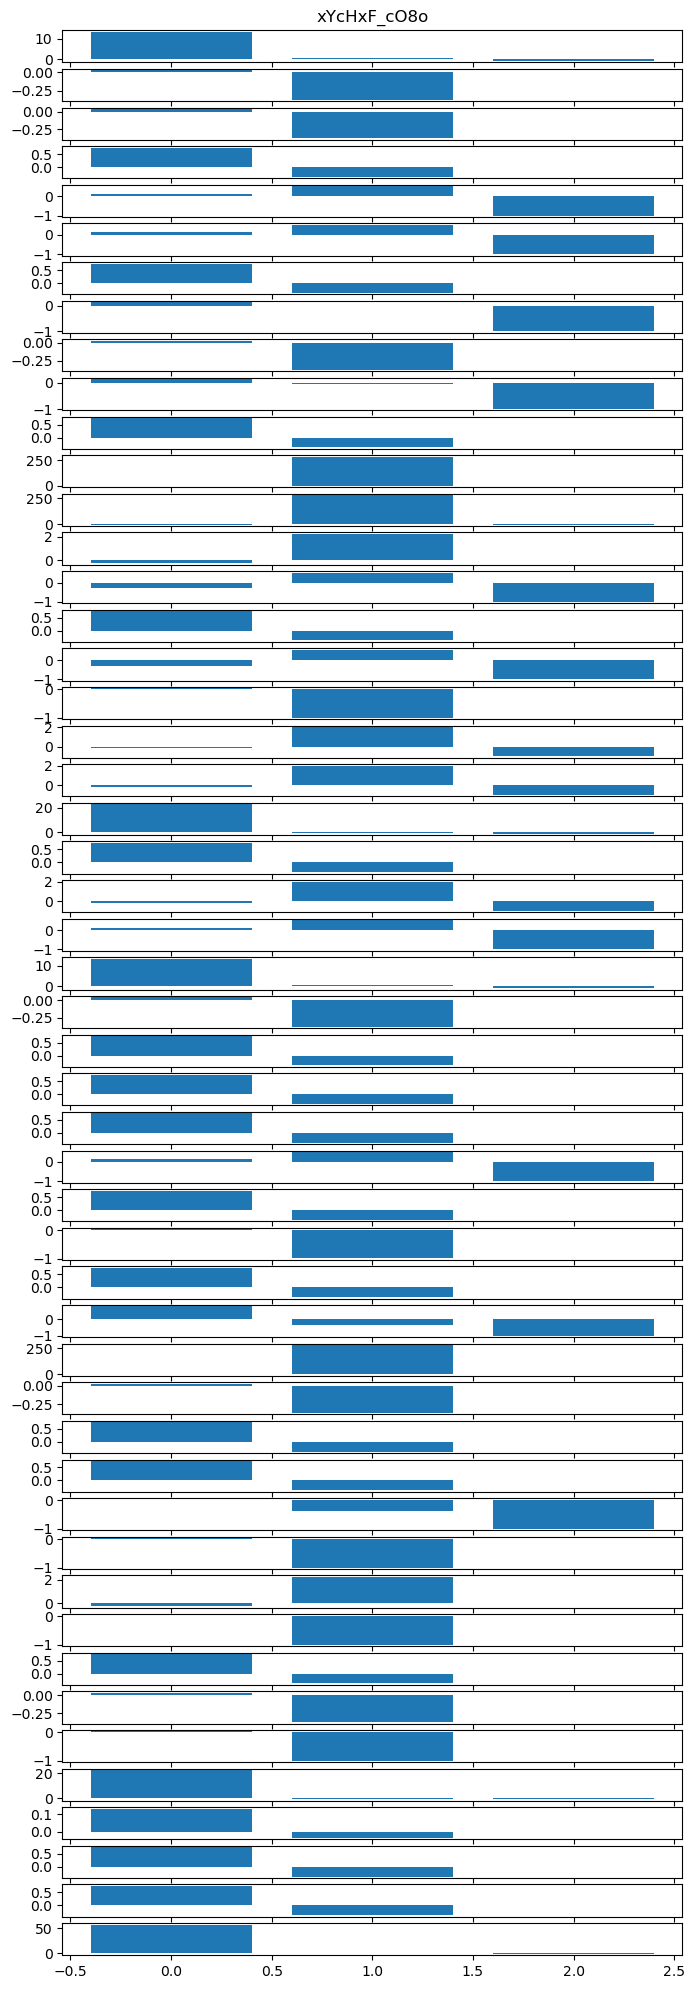

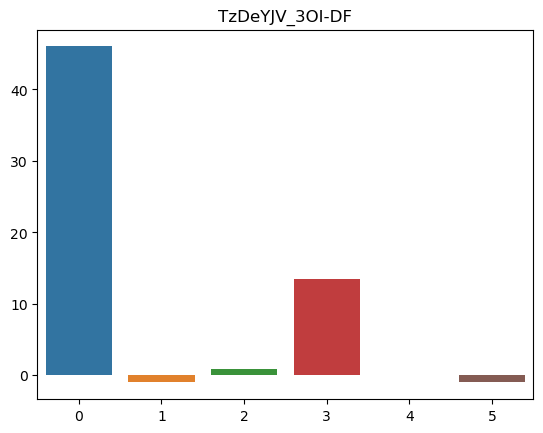

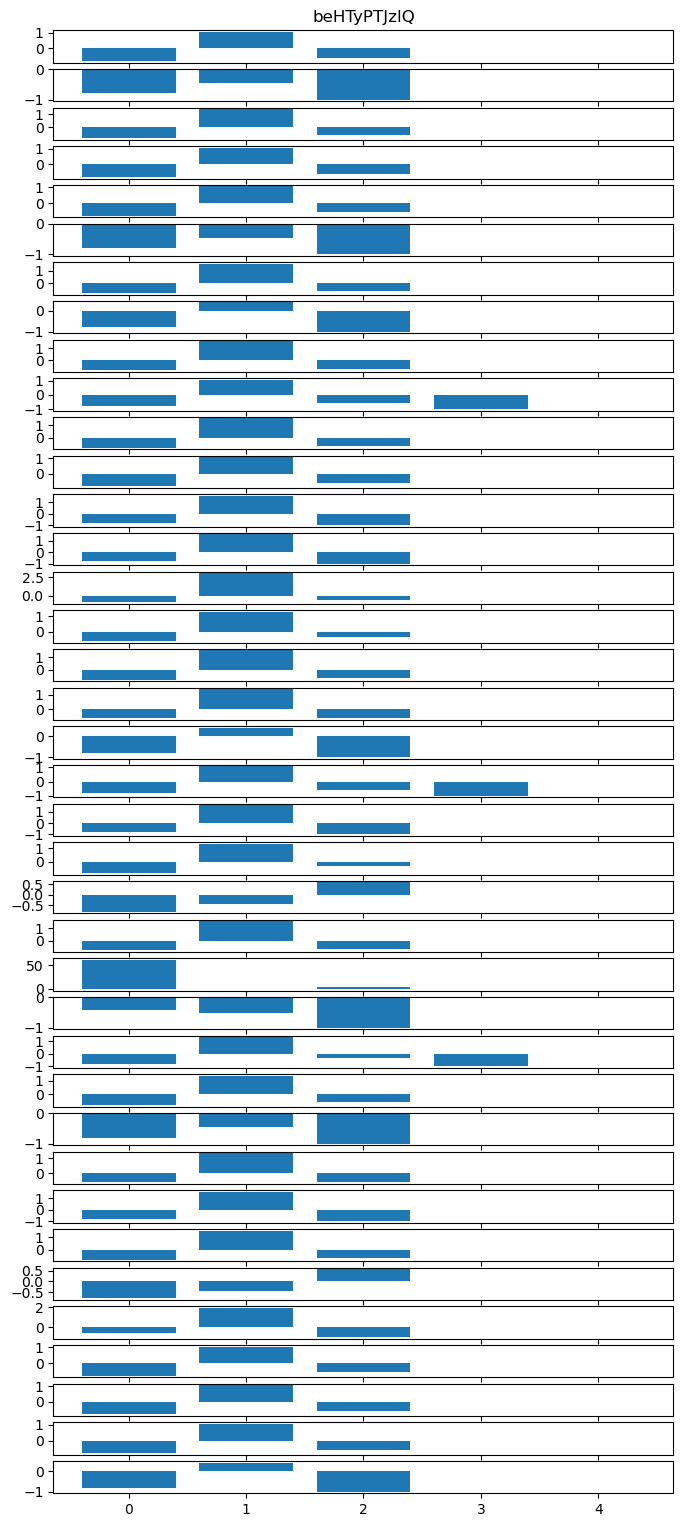

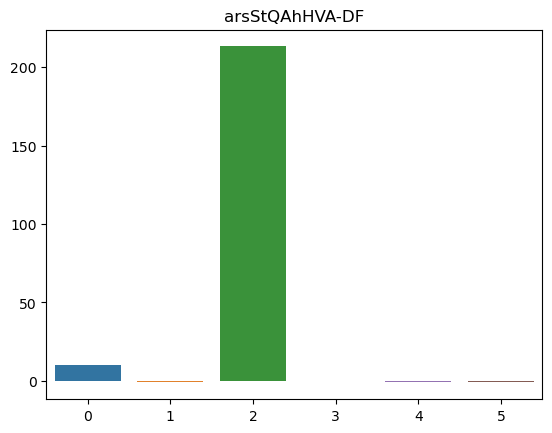

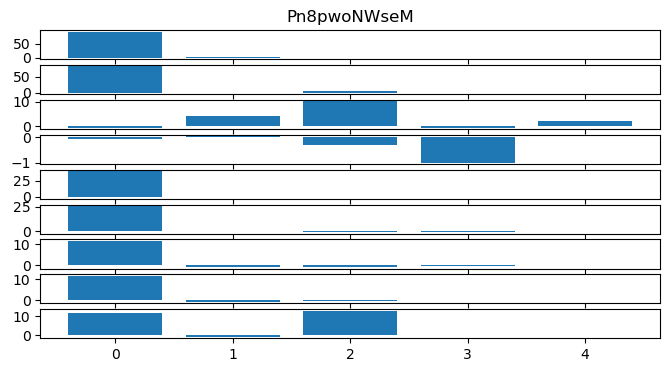

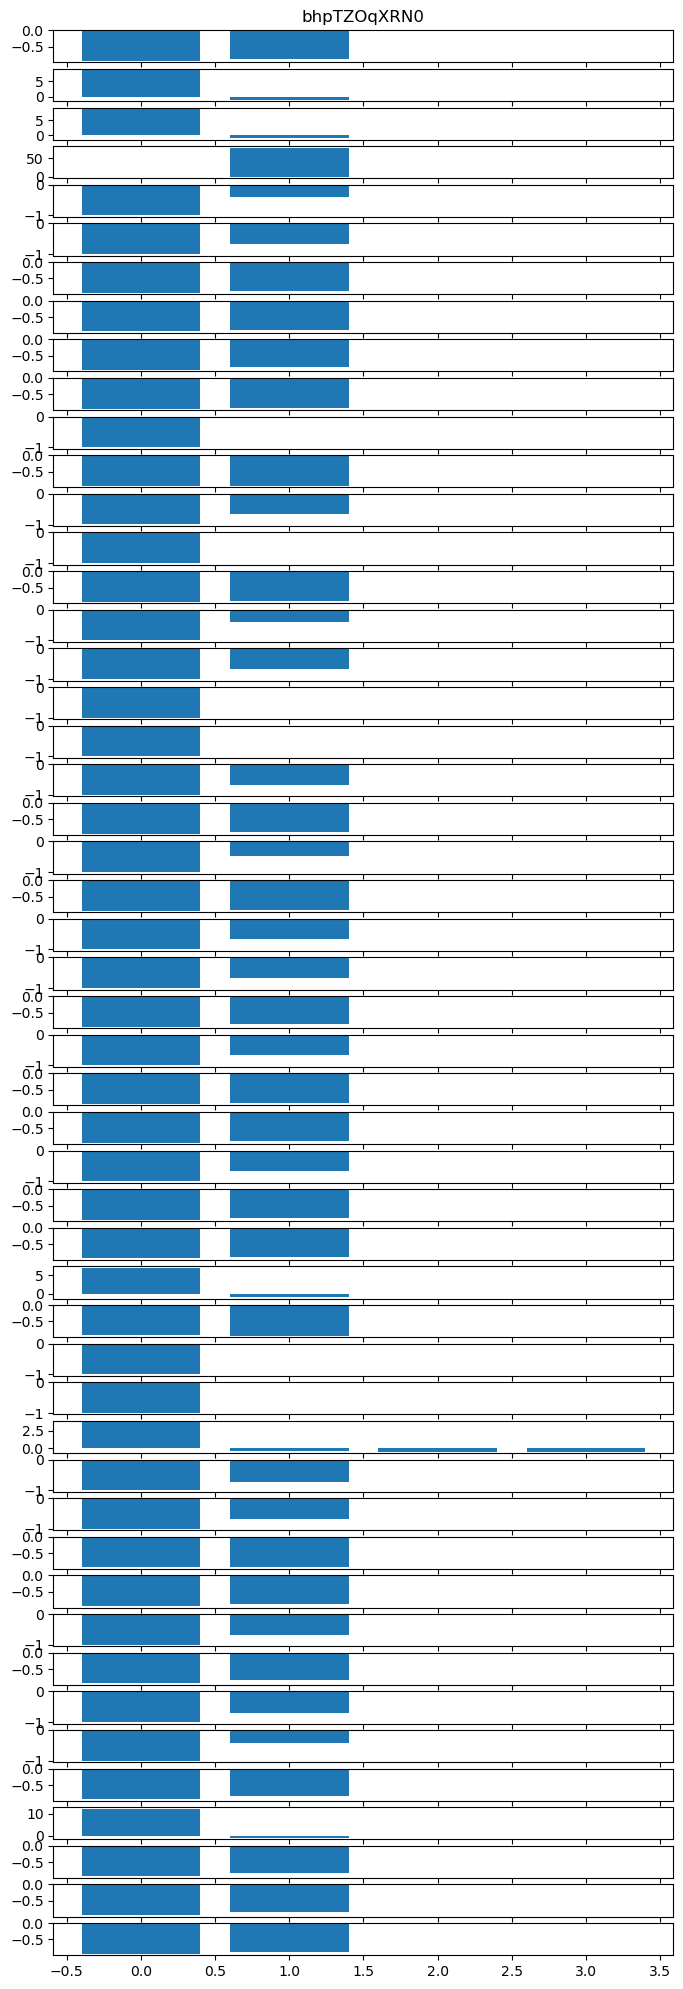

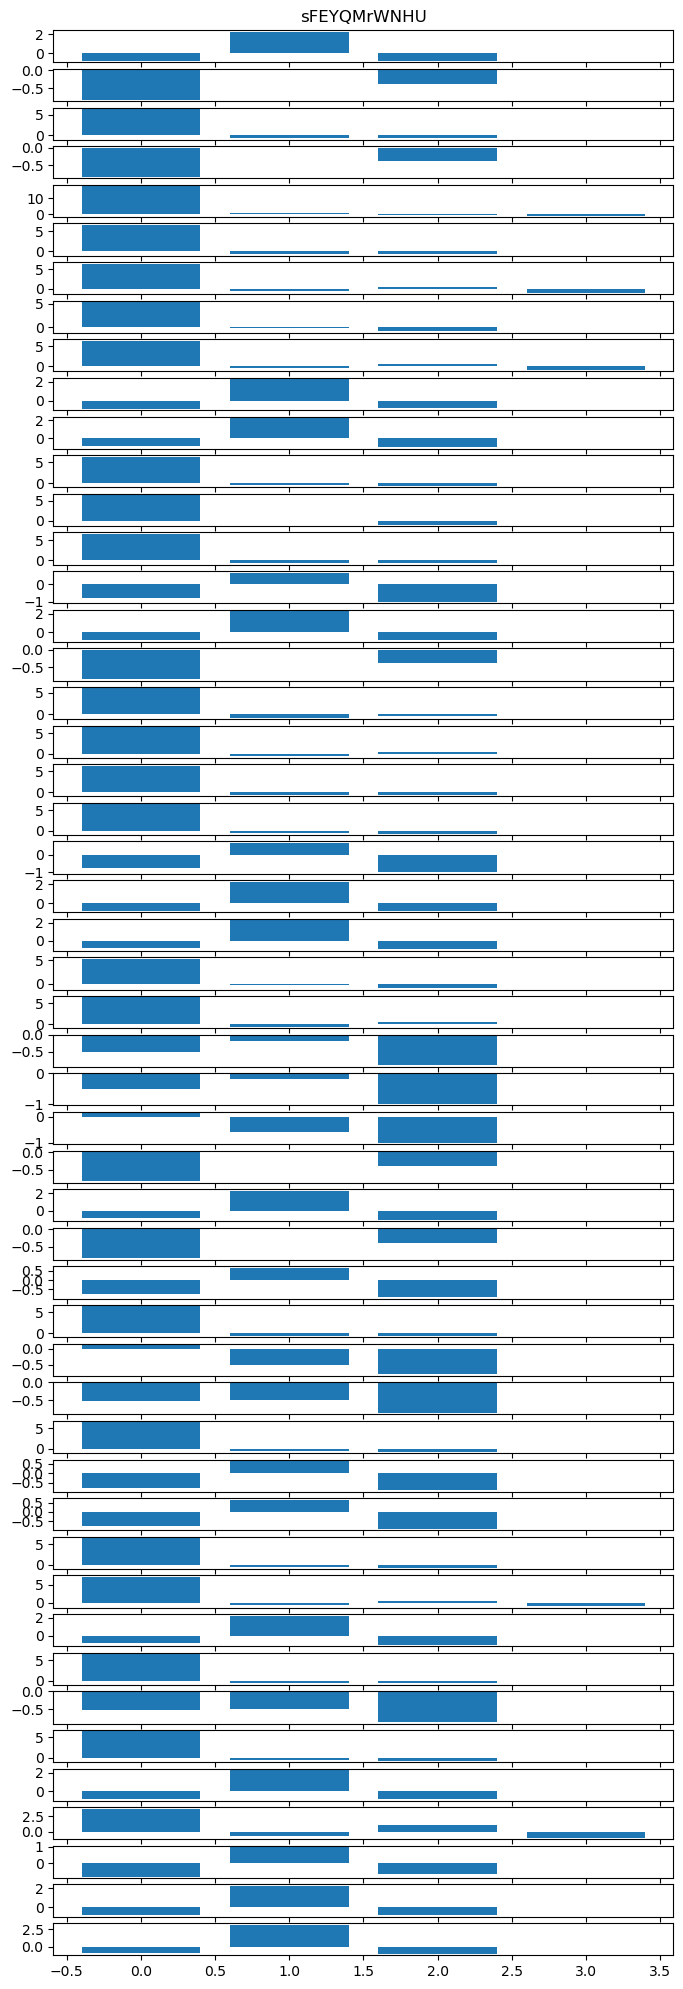

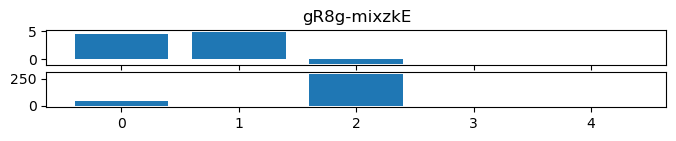

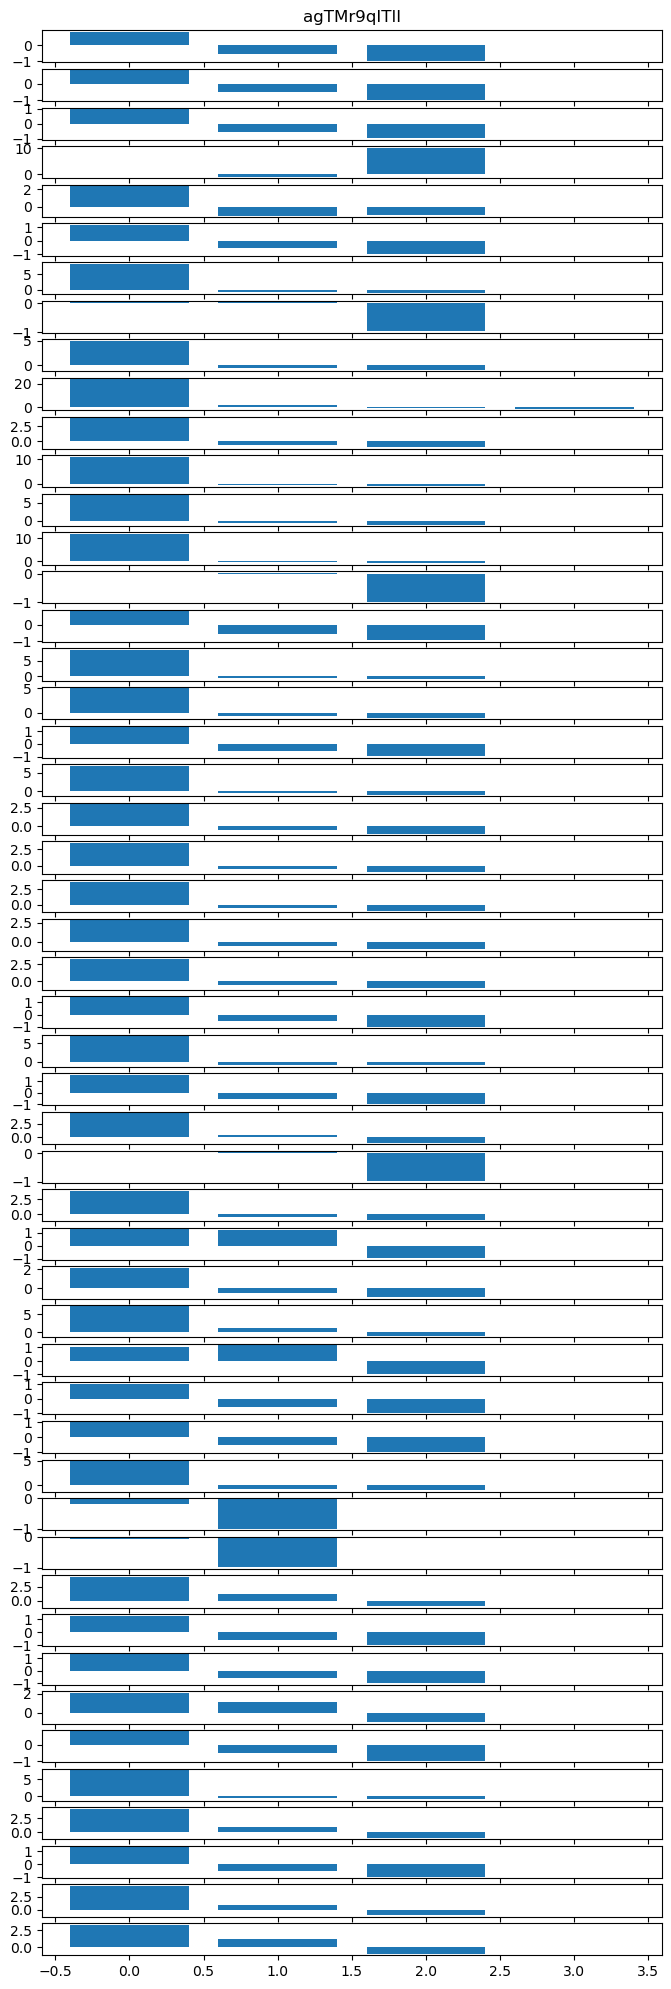

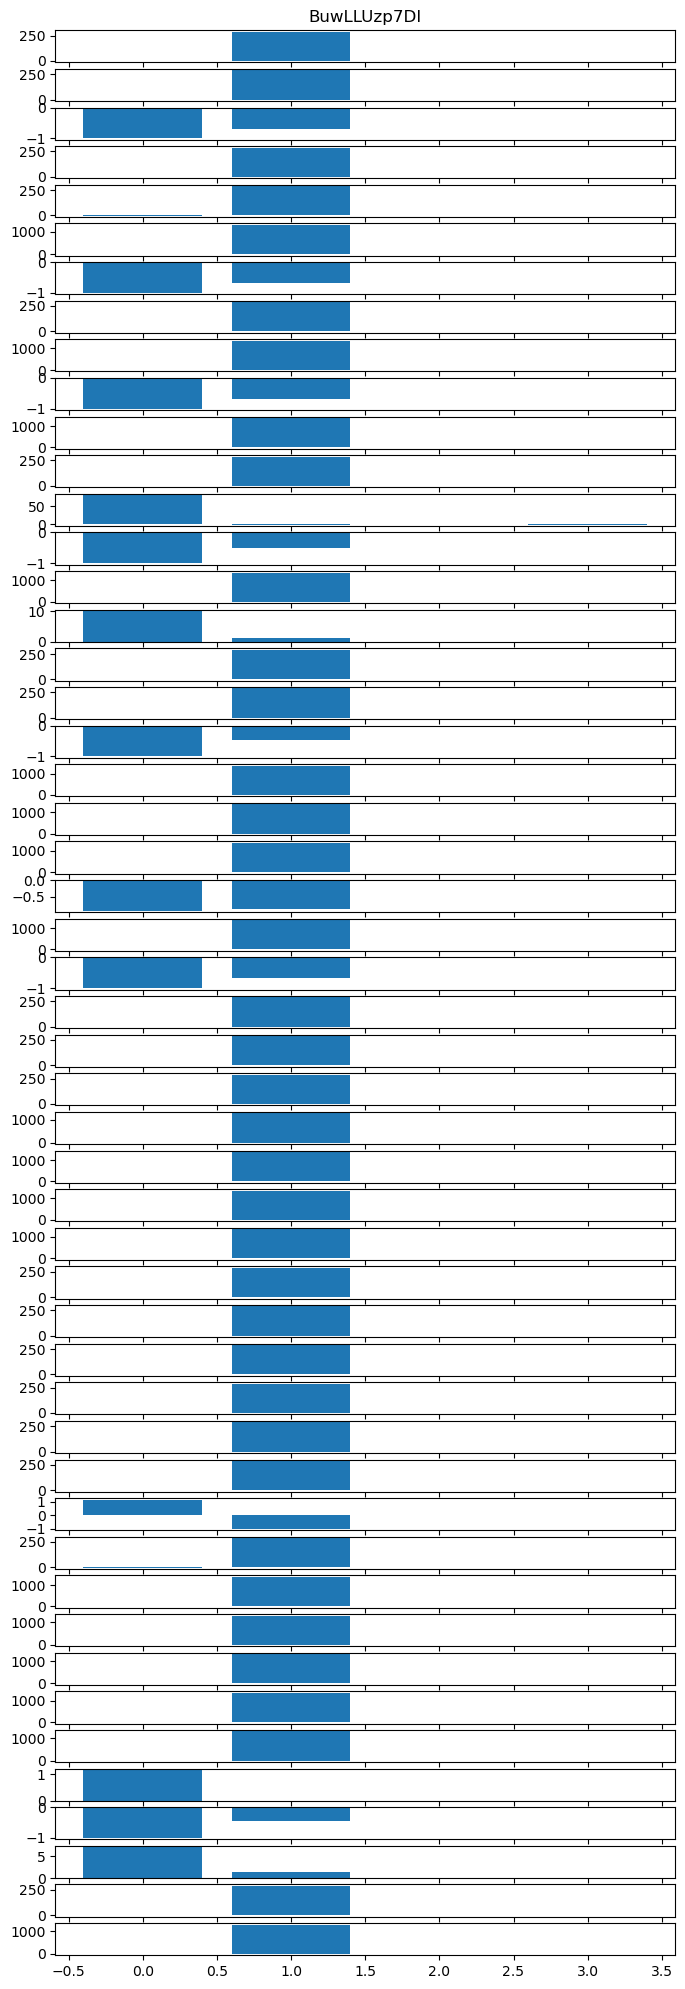

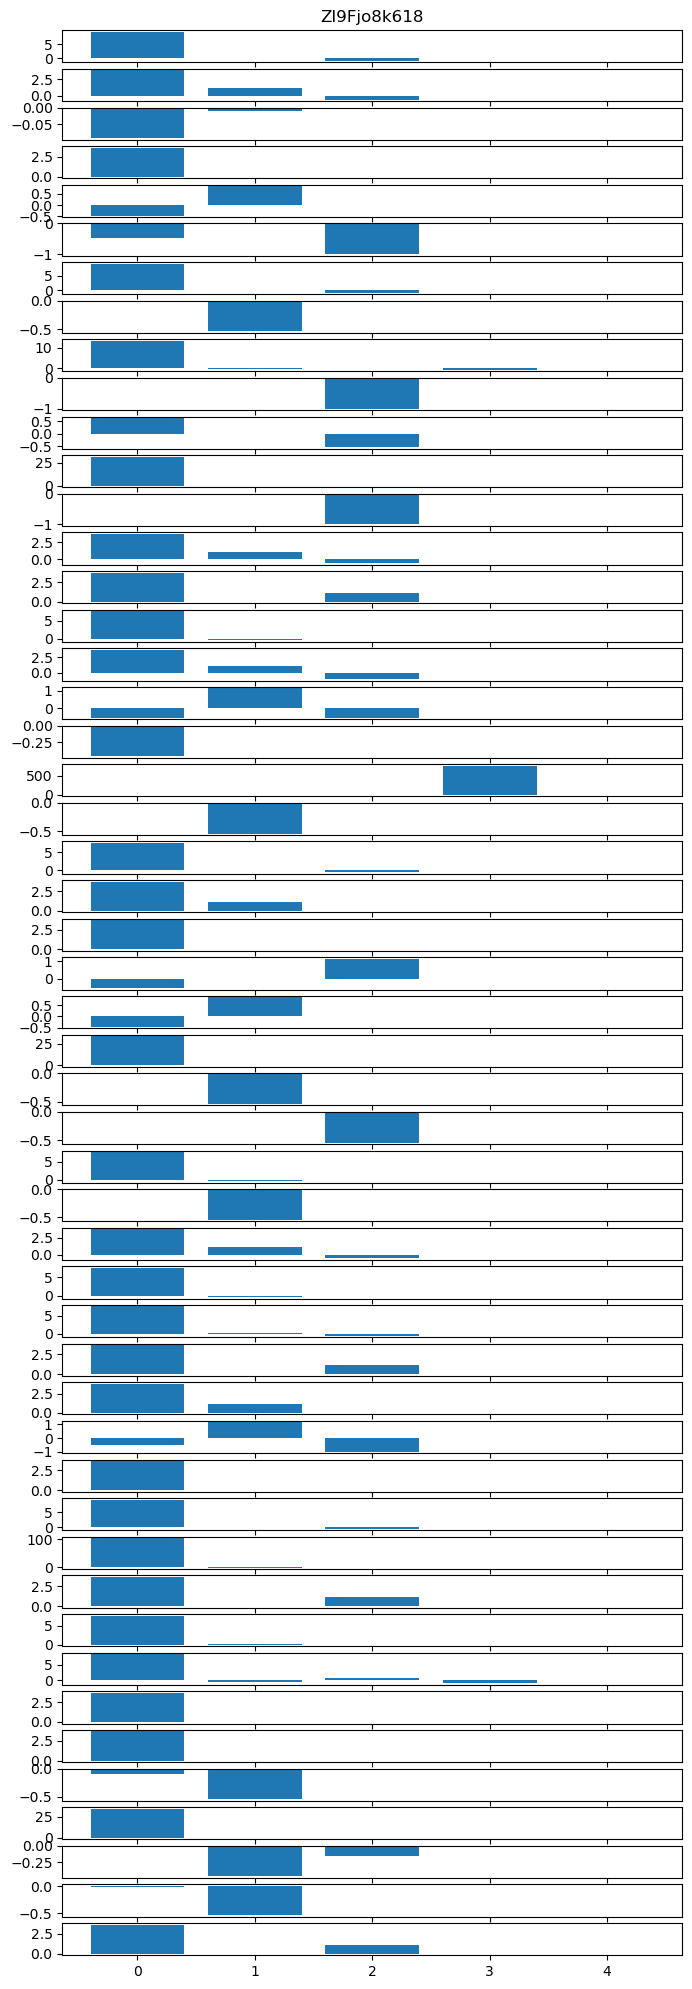

In [ ]:
bit_column = "DF"
for idx in list(range(len(video_ids))):
    fn = video_ids[idx]
    bit_data = test[bit_column][youtube_data["video_id"] == fn].reset_index(drop=True)


    len_data = len(bit_data)
    if(len_data>1):
        fig, axs = plt.subplots(nrows=len_data,  figsize=(8,int(len_data/2)),sharex='col' )
        for i in range(len_data):
            y = bit_data[i]
            x = list(range(len(y)))
            axs[i].bar(x,y)
        axs[0].set_title(fn)
    else:
        plt.title(fn+"-"+bit_column)
        y = list(bit_data)[0]
        x = list(range(len(y)))
        sns.barplot(x=x, y=y)
    plt.show()

### 5 - How unique are the video traces?

Test 1: withingroup similarities

- Cross join to join all fingerprints of one video with each other
- Get the dtw distance
- See if the average dtw distance is the same



- Test the distance data points for normality, if not normal use the Wilcoxon test
- Create a hypothesis test to see if they are significantly different
- Alpha = 0.05


- Use a Wilcoxon sink-rank test to see if the data is 

In [ ]:
data2 = data[["video_id", "data"]]
data2 = data2.groupby("video_id").sum()
my_data = data2.to_numpy().flatten().tolist()
my_data

[[0.0,
  5861.0,
  5601.0,
  5861.0,
  73006.0,
  34397.0,
  5200.0,
  187691.0,
  3856.0,
  26825.0,
  19862.0,
  2907904.0,
  3011256.0,
  16521.0,
  2634912.0,
  1712.0,
  18860.0,
  2200.0,
  3056524.0,
  595463.0,
  1190.0,
  1238.0,
  2601696.0,
  1646.0,
  0.0,
  5861.0,
  885.0,
  73006.0,
  5536.0,
  34381.0,
  187591.0,
  26825.0,
  3856.0,
  5166.0,
  19862.0,
  2905882.0,
  16521.0,
  1564.0,
  18862.0,
  2163.0,
  22238331.0,
  2342845.0,
  1191.0,
  1237.0,
  1659559.0,
  2175808.0,
  1645.0,
  1749391.0,
  0.0,
  5861.0,
  73006.0,
  5861.0,
  6093.0,
  5039.0,
  34851.0,
  26826.0,
  3856.0,
  19862.0,
  189471.0,
  2889858.0,
  16521.0,
  1726.0,
  18862.0,
  20051489.0,
  2161.0,
  2192021.0,
  1190.0,
  2342845.0,
  1659559.0,
  1237.0,
  2175808.0,
  1645.0,
  1749391.0,
  5861.0,
  5861.0,
  73006.0,
  5876.0,
  26826.0,
  5206.0,
  34473.0,
  3856.0,
  19862.0,
  2883266.0,
  192060.0,
  3011256.0,
  16521.0,
  2634912.0,
  1713.0,
  18862.0,
  2108.0,
  3056524.0

In [ ]:
len(group_data[0])

1512900

In [ ]:
my_data[2]

[0.0,
 0.0,
 5861.0,
 5861.0,
 5890.0,
 72784.0,
 11322.0,
 25446.0,
 4968.0,
 1742993.0,
 26827.0,
 2412.0,
 35017.0,
 81773.0,
 20191.0,
 2796948.0,
 2557107.0,
 1730.0,
 2235651.0,
 22263.0,
 2374254.0,
 2162.0,
 2139513.0,
 1374.0,
 4711181.0,
 429516.0,
 1647.0,
 5861.0,
 5861.0,
 5932.0,
 72784.0,
 25446.0,
 5673.0,
 34888.0,
 1742993.0,
 26827.0,
 2412.0,
 87525.0,
 20191.0,
 2789912.0,
 2557107.0,
 1889.0,
 2235651.0,
 22263.0,
 2374254.0,
 2298.0,
 2139513.0,
 1237.0,
 4711181.0,
 1190.0,
 429516.0,
 1508.0,
 1190.0,
 0.0,
 5861.0,
 5664.0,
 5861.0,
 72784.0,
 11322.0,
 25446.0,
 26827.0,
 81846.0,
 5119.0,
 1742993.0,
 20189.0,
 34945.0,
 2412.0,
 2797031.0,
 2557107.0,
 1599.0,
 2235651.0,
 22288.0,
 2374254.0,
 2200.0,
 2139513.0,
 1191.0,
 2323230.0,
 2393130.0,
 1237.0,
 429516.0,
 1646.0,
 0.0,
 5861.0,
 5861.0,
 72784.0,
 6067.0,
 25446.0,
 4742.0,
 1742993.0,
 34931.0,
 2412.0,
 83642.0,
 26827.0,
 20189.0,
 2796149.0,
 2557107.0,
 1762.0,
 2235651.0,
 22263.0,
 237425

In [ ]:
# Step 1: Calculate pairwise distances within each group
group_data = []  # List to store data for each group

# Assuming you have a 2D array 'data' with shape (n_groups, n_samples_per_group)
for group in my_data:
    group_paired_data = [(x, y) for x in group for y in group]
    distances = [get_distance(x,y) for (x,y) in group_paired_data]
    #distances = np.abs(np.subtract.outer(group, group))  # Calculate pairwise distances
    group_data.append(distances) #.flatten())  # Flatten distances and store in group_data

video_ids = data.index
# Withingroup didtances
for idx in list(range(len(data))):
    video_id = video_ids[idx]
    print("Wilcoxon signed-rank test for: ", video_id)

    if len(group_data[idx]) > 1:
        statistic, p_value = stats.wilcoxon(group_data[idx])
        if p_value < 0.05: print("No difference")
        else: 
            print("Different")
            pass
        print("\n")
    else:
        print("problem:",group_data[idx])



# Step 2: Calculate pairwise distances between different groups
between_group_distances = []

for i, group_i in enumerate(data):
    for j, group_j in enumerate(data):
        if i != j:
            group_paired_data = [(x, y) for x in group_i for y in group_j]
            distances = [get_distance(x,y) for (x,y) in group_paired_data]
            #distances = np.abs(np.subtract.outer(group_i, group_j))  # Calculate distances between groups
            between_group_distances.extend(distances)#.flatten())  # Flatten distances and store in between_group_distances


# Step 3: Perform the Kruskal-Wallis test
print("Kruskal-Wallis test for between group difference")
h_statistic, p_value = stats.kruskal(*group_data)

# Step 4: Post-hoc analysis
if p_value < 0.05:  # Significant difference between groups
    print("Groups are significantly different")
    print()
    print("Post hoc analysis")
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            # Perform pairwise Mann-Whitney U tests for post-hoc analysis
            u_statistic, mw_p_value = stats.mannwhitneyu(group_data[i], group_data[j])
            if mw_p_value < 0.05:
                print(f"Significant difference between  {video_ids[i]} and  {video_ids[j]}")

KeyboardInterrupt: 

In [ ]:
# I assume that the fingerprint with the highest variance has the most information and is thus the best for dtw. 
# sort the traces by variance, and get the average distances to the fingerprint, plot the distances
# check if the differences within the groups are significnantly smaller than the differences between the groups 

# For the eda: how many data points per second in each trace?. Violin plot of one 
# Violin plots of each trace for each video in a row similar to what I have seen before
# I want to know where to put the cut off. 

### 6 - How well does an average fingerprint fair for the prediction?

## Sources

[1] J. Gu, J. Wang, Z. Yu, and K. Shen, ‘Walls Have Ears: Traffic-based Side-channel Attack in Video Streaming’, in IEEE INFOCOM 2018 - IEEE Conference on Computer Communications, Apr. 2018, pp. 1538–1546. doi: 10.1109/INFOCOM.2018.8486211.
